##  abTEM STEM, PRISM, and 4DSTEM simulation tutorial

This notebook shows:
- how to run STEM simulations in abTEM
- how to use the PRISM algorithm to speed up STEM simulations
- how to run a 4DSTEM simulations
- Bonus - interactive widgets now added!

### Authors

- Colin Ophus (cophus@stanford.edu)
- Stephanie Ribet (sribet@lbl.gov)
- The abTEM authors

Last updated: 2025 Apr 13.



In [2]:
# Install abTEM, which includes ASE and many other packages
!pip install abtem > /dev/null 2>&1
# !pip install git+https://github.com/abtem/abtem.git@master > /dev/null 2>&1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase
from ase.visualize import view

## Build 2D material atomic model

STEM simulations in general take a LOT longer than TEM simulations. The primary reason is that when doing a plane wave TEM simulation, we only need to run the multislice algorithm a single time to propagate the electron wave through the sample.  Or, if we're using Frozen phonons, ~8-32 times depending on sample thickness.

However, each probe position in STEM requires another full multislice simulation. If we wanted to simulate 1000x1000 probe positions, our simulation would take 1,000,000 times longer than a TEM simulation of the same dimensions! Therefore, most researchs only simulate a small field of view for STEM simulations, often only a few unit cells. Recently, I developed an alternative algorithm named PRISM, which can dramatically speed up atomic resolution simulations in some cases.

Here, we're going to simulate TEM experiments from a 2D material (graphene) in order to speed up computational times. We will make the more interesting by adding some dopant atoms, and large enough to take advantage of PRISM.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Beam view'}, xlabel='x [Å]', ylabel='y [Å]'>)

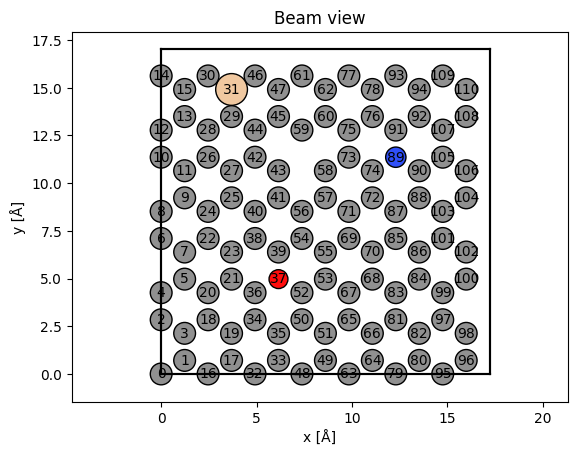

In [4]:
# Build an orthogonzlized graphene unit cell which is just under 2x2 nm
atoms = abtem.atoms.orthogonalize_cell(
    ase.build.graphene(vacuum=2),
)

# Dope the graphene by replacing a C atom with N, O, Si and a vacancy,
# roughly in the 4 corners. Hint - using `numbering = True` and `scale_atoms`
# in the atomic plotting function will make your task much easier!

atoms *= (7,4,1)
del atoms[58] #remove the 58th atom
atoms.numbers[89] = 7
atoms.numbers[37] = 8
atoms.numbers[31] = 14


# Plot the resulting structure
abtem.show_atoms(
    atoms,
    title="Beam view",
    numbering = True,
    merge = False,
    # scale_atoms = 1.0,
)

We can see that our cell is large enough to seaprate the point defects we introduced by >5 A, which is sufficient for atomic resolution imaging of a 2D material.  However, if you were simulating a thick sample, you would likely need to keep only a single defect per simulation cell in order to prevent interference artifacts.

Next, create the projected potential using
```
abtem.FrozenPhonons()
abtem.Potential()
```

Let's start with 8 frozen phonon configurations, atomic RMS displacements of 0.08 A, and 0.16 A sampling.

In [5]:
frozen_phonons = abtem.FrozenPhonons(
    atoms,
    num_configs = 8,
    sigmas = 0.08,

)
potential = abtem.Potential(
    frozen_phonons,
    sampling = 0.16,
    slice_thickness = 2,

)

[########################################] | 100% Completed | 562.03 ms


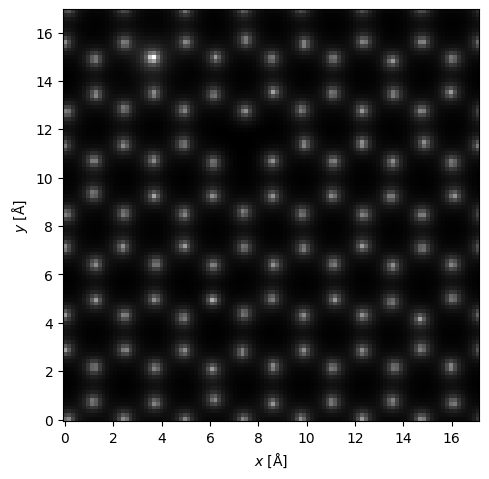

In [6]:
# plot the projected potential
potential.build().project().show(
    cmap='gray'
);

In [7]:
potential.build().array.shape

(8, 2, 108, 107)

## STEM probe wavefunctions

We will define our probe using
```
abtem.Probe()
```

We will do some plotting of the 2D image and 1D line traces to better understand the probe. We can access this wavefunction using
```
probe_wavefunction = probe.build().array
```

The most important parameters are energy and semiangle_cutoff. Let's use 80 kV and 25 mrads respectively.

[########################################] | 100% Completed | 100.88 ms
[########################################] | 100% Completed | 102.70 ms


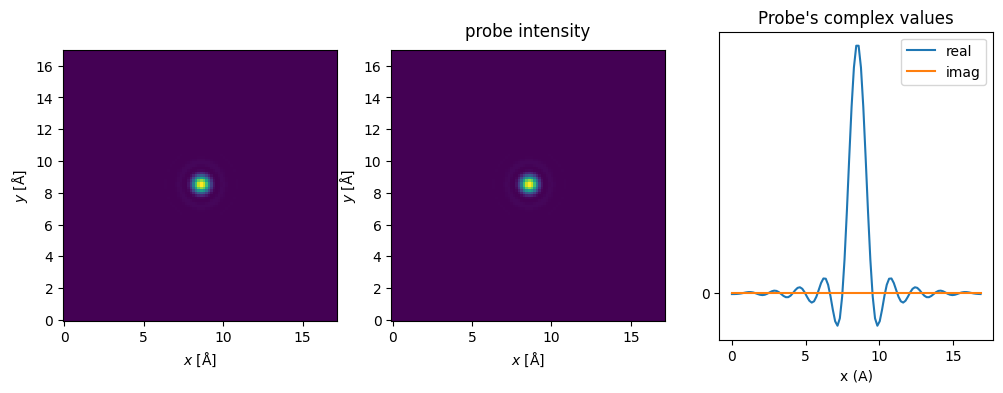

In [8]:
semiangle_cutoff = 25

probe = abtem.Probe(
    energy = 80e3,
    semiangle_cutoff=semiangle_cutoff,
    defocus = 0,
)

# This function copies the extent and sampling values from potential to probe
probe.grid.match(potential)

# plot the STEM probe wavefunction
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
probe.show(ax=ax[0])
probe.show(
    ax=ax[1],
    title = 'probe intensity',
);

# plot a line trace of the probe wavefunction complex values

probe_wavefunction = probe.build().array
x_ind = probe_wavefunction.shape[0] // 2
y_ind = probe_wavefunction.shape[1] // 2

x = np.arange(probe_wavefunction.shape[1])* probe.sampling[1]
y = probe_wavefunction[x_ind, :, ]
ax[2].plot(
    x,
    np.real(y),
    label = 'real',
)
ax[2].plot(
    x,
    np.imag(y),
    label = 'imag',
)
ax[2].legend()
ax[2].set_xlabel('x (A)')
ax[2].set_title('Probe\'s complex values')
ax[2].set_yticks([0])



# Estimate the RMS probe size

# print(f"FWHM = {x_rms:.3f} Å")

Having a defocus on the probe gives the wave function complex parts.

When the defocus becomes too big, we can have a weird probe. Because of periodic boundary condition, we have interference.

# STEM probe scan field of view

One of the key differences between TEM and STEM experiments is that in STEM, we change the initial condition of the electron wavefunction many times and repeat the experiment (i.e. we scan the beam over the sample surface).

In abtem, we can define a grid of scan positions using
```
abtem.GridScan()
```

We will need to specify the start and end corners of our scan box, as well  as the sampling (keep in mind this is NOT the wavefunction sampling, this is sampling of the STEM probes). We can access some useful values here:
```
potential.extent #how far the box is
probe.ctf.nyquist_sampling
```

We can also overlay our scan box over the atomic potentials to make sure we're scanning the correct field of view.

Why can we use nyquist sampling for the STEM probe positions?

[########################################] | 100% Completed | 219.57 ms


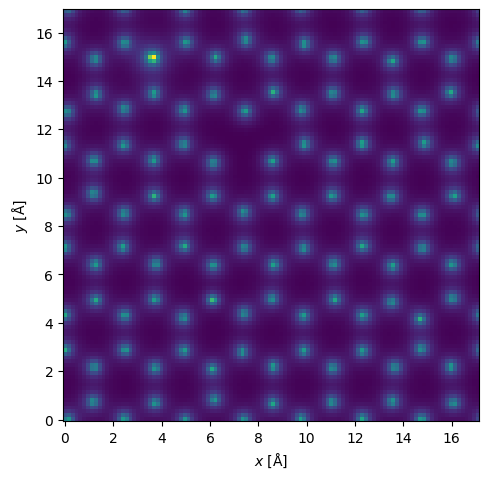

In [9]:
potential.show()

[########################################] | 100% Completed | 103.92 ms


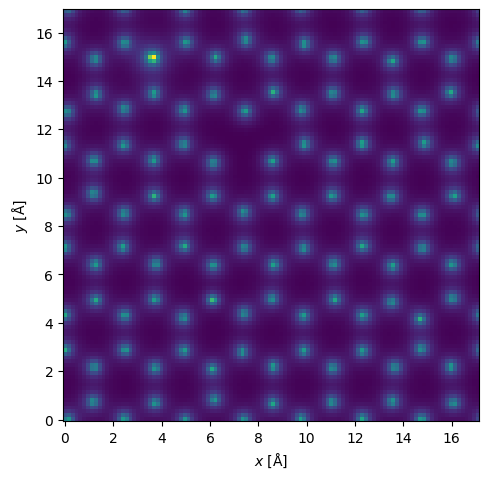

In [10]:
object = potential.show()

In [11]:
object.axes

[########################################] | 100% Completed | 232.92 ms


AttributeError: 'GridScan' object has no attribute 'add_to_mpl_plot'

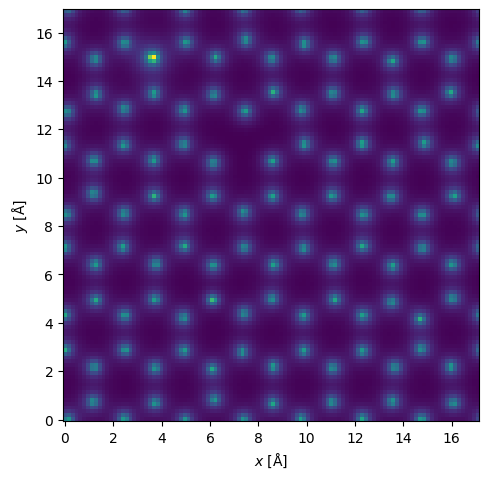

In [13]:
gridscan = abtem.GridScan(
    start = [0,0],
    end = potential.extent,
    sampling = probe.ctf.nyquist_sampling * 1,
)

# Plot the projected potential, with the scanning box overlaid
ax = potential.show()
gridscan.add_to_mpl_plot(ax)



## STEM Detector

Say we want to simulate a few different kinds of bright field and dark field detectors. These detectors are all circular or annualar.

We could simulate them all at the same time, but we would still need to define them ahead of time. If we use the FlexibleAnnularDetector() class, we can store the data as a function of the electron scattering angle. This will allow us to decide on the inner and outer angles after the simulation, i.e. with a lot more flexibility.

In [ ]:
# Time the simulation for a later comparison
%%time

flexible_detector = abtem.FlexibleAnnularDetector()

flexible_measurement = probe.scan(
    scan = gridscan,
    detectors = flexible_detector,
    potential = potential,

    # pbar=False,
)

Potential:   0%|          | 0/2 [00:00<?, ?it/s]

TDS:   0%|          | 0/8 [00:00<?, ?it/s]

Scan:   0%|          | 0/1681 [00:00<?, ?it/s]

CPU times: user 2min 34s, sys: 2.78 s, total: 2min 36s
Wall time: 1min 34s


In [ ]:
flexible_measurement.array.shape

(41, 41, 86)

To specify a radial detector range, we can use this method
```
flexible_measurement.integrate()
```

To upsample the resulting image, we can use
```
measurement.interpolate()
```

In [ ]:
flexible_measurement.integrate(
    semiangle_cutoff * 0.0,
    semiangle_cutoff * 1.0
)

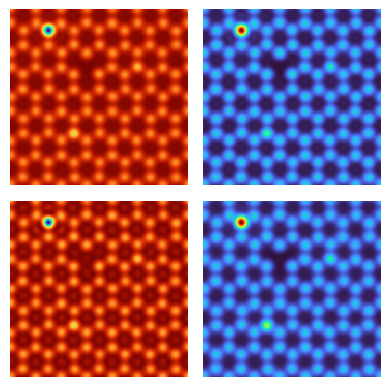

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (4,4))

meas_bf = flexible_measurement.integrate(
    semiangle_cutoff * 0.0,
    semiangle_cutoff * 1.0
)
meas_abf = flexible_measurement.integrate(
    semiangle_cutoff * 0.5,
    semiangle_cutoff * 1.0
)

meas_adf = flexible_measurement.integrate(
    semiangle_cutoff * 1.0 + 0.5,
    semiangle_cutoff * 2.0

)
meas_haadf = flexible_measurement.integrate(
    semiangle_cutoff * 2.0,
    semiangle_cutoff * 4.0
)

samp_output = 0.1
cmap = 'turbo'
meas_bf.interpolate(samp_output).show(ax = ax[0,0], cmap = cmap,)
meas_abf.interpolate(samp_output).show(ax = ax[1,0], cmap = cmap)
meas_adf.interpolate(samp_output).show(ax = ax[0,1], cmap = cmap)
meas_haadf.interpolate(samp_output).show(ax = ax[1,1], cmap = cmap)

ax[0,0].axis('off');
ax[0,1].axis('off');
ax[1,0].axis('off');
ax[1,1].axis('off');
fig.tight_layout()

# Noisy measurements

For this simulation of a 2D material, all 4 detectors seem to produce similar contrast.  But is this really true?

To properly evaluate the imaging quality, we need to use a realistic electron fluence (dose). Electron fluence is typically specified in units of electrons / Angstrom^2. If we manually compute the output images, we need to make sure to convert to units of "electrons per probe."




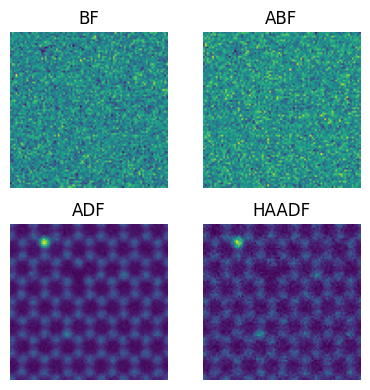

In [ ]:
# Calculate the noisy images and plot them
dose_per_A2 = 1e6
samp_output = 0.2
dose_per_probe_position = dose_per_A2 * samp_output**2

im_bf = np.random.poisson(
    dose_per_probe_position * meas_bf.interpolate(samp_output).array
)
im_abf = np.random.poisson(
    dose_per_probe_position * meas_abf.interpolate(samp_output).array
)
im_adf = np.random.poisson(
    dose_per_probe_position * meas_adf.interpolate(samp_output).array
)
im_haadf = np.random.poisson(
    dose_per_probe_position * meas_haadf.interpolate(samp_output).array
)


# Note that we need to rotate all images by 90 degrees,
# to match the default abTEM plotting axes.
fig,ax = plt.subplots(2,2,figsize = (4,4))
ax[0,0].imshow(np.rot90(im_bf,1),)
ax[0,1].imshow(np.rot90(im_abf,1))
ax[1,0].imshow(np.rot90(im_adf,1))
ax[1,1].imshow(np.rot90(im_haadf,1))

ax[0,0].axis('off');
ax[0,0].set_title('BF')
ax[0,1].axis('off');
ax[0,1].set_title('ABF')
ax[1,0].axis('off');
ax[1,0].set_title('ADF')
ax[1,1].axis('off');
ax[1,1].set_title('HAADF')
fig.tight_layout()

Which imaging mode is the most efficient?  

Which is the least efficient?

Why do you think these images produce such vastly different amounts of contrast?

## PRISM

The above simulations took a little while to compute. This is because we are simulating an entirely new multislice simulation for each STEM probe position.  Even if we simulate at Nyquist frequency, this is a lot of simulations!

However, when we are working at atomic resolution, most of the probe wavefunction intensities are ~0. So one way to speed up the simulation is to crop around the probe as propagate.  This leads to an f**2 speedup, for a cropping factor "f" applied in the x and y directions. However, we can do even better by using the PRISM algorithm. PRISM works by decomposing the multislice simulations into a series of plane wave simulations, and then rather than only cropping the output probes, we also apply Fourier interpolation.

The full algorithm is beyond of the scope of this workshop, but you can find more information here if you are interested:
- [PRISM algorithm paper](https://doi.org/10.1186/s40679-017-0046-1)
- [Prismatic simulation paper](https://doi.org/10.1186/s40679-017-0048-z)
- [abTEM guide to PRISM](https://abtem.readthedocs.io/en/latest/user_guide/tutorials/prism.html)

For now, we are going to use PRISM to compute the same STEM simulations as above, and estimate the speed up / loss of accuracy if any.

Note - in this version of abTEM, using the scattering matrix is a bit tedious and so we have included all of the code you need below. For a look at the modern abTEM implementation of PRISM, see the link above.

In [ ]:
# Time the scattering matrix calculation.
%%time

S = abtem.SMatrix(
    # expansion_cutoff = 25,
    interpolation = 2, #many tilted planewaves
    energy = 80e3,
    semiangle_cutoff = semiangle_cutoff,
    defocus = 0
    # C10 = 25,
    # C30 = -10e4,
    # C50 = 5e7,
)

measurement = S.scan(
    gridscan,
    flexible_detector,
    potential,
    pbar = False,
)
S_array = S.build()

exit_S_array = S_array.multislice(potential)
exit_S_array.ctf.semiangle_cutoff = semiangle_cutoff
exit_S_array.ctf.defocus = 0

prism_meas = exit_S_array.scan(gridscan, [flexible_detector]);

Multislice:   0%|          | 0/2 [00:00<?, ?it/s]

Scan:   0%|          | 0/1681 [00:00<?, ?it/s]

CPU times: user 11.3 s, sys: 195 ms, total: 11.5 s
Wall time: 7.13 s


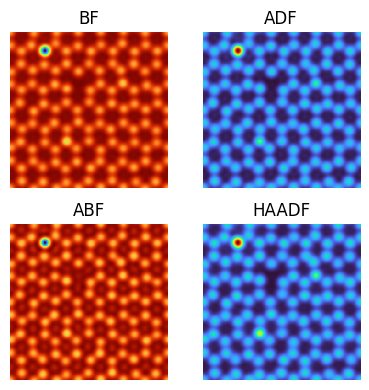

In [ ]:
# plot the results
fig,ax = plt.subplots(2,2,figsize = (4,4))

meas_bf = prism_meas.integrate(
    semiangle_cutoff * 0.0,
    semiangle_cutoff * 1.0
)
meas_abf = prism_meas.integrate(
    semiangle_cutoff * 0.5,
    semiangle_cutoff * 1.0
)

meas_adf = prism_meas.integrate(
    semiangle_cutoff * 1.0 + 0.5,
    semiangle_cutoff * 2.0

)
meas_haadf = prism_meas.integrate(
    semiangle_cutoff * 2.0,
    semiangle_cutoff * 4.0
)

samp_output = 0.05
cmap = 'turbo'
meas_bf.interpolate(samp_output).show(ax = ax[0,0], cmap = cmap,)
meas_abf.interpolate(samp_output).show(ax = ax[1,0], cmap = cmap)
meas_adf.interpolate(samp_output).show(ax = ax[0,1], cmap = cmap)
meas_haadf.interpolate(samp_output).show(ax = ax[1,1], cmap = cmap)

ax[0,0].axis('off');
ax[0,0].set_title('BF')
ax[0,1].axis('off');
ax[0,1].set_title('ADF')
ax[1,0].axis('off');
ax[1,0].set_title('ABF')
ax[1,1].axis('off');
ax[1,1].set_title('HAADF')
fig.tight_layout()

## 4DSTEM simulations

So far, we have only simulated conventional STEM detectors. abTEM can also simulate more complex detectors such as segmented detectors. However, the most flexible detector of them all is to save the full image of the diffracted STEM probe, at each probe position. This data can be used for a whole host of experiments, collectivelyk known as four-dimensional STEM (4DSTEM) due to the shape of the output data (2D images over a 2D grid of positions = 4D).

From a simulation perspective, 4DSTEM simulations are easily accomplished. We simply need to keep the full 4D output. The main difficulty arises from the size of the dataset. For example consider the dataset sizes for a 500x500 scan position simulation saved as floating point numbers (4 bytes per pixel). For a flexible detector, we can assume 100 radial bins are stored. For a 4DSTEM experiment, we will store 100x100 sized diffraction pattern outputs. The output dataset size as a function of the number of dimensions will be:
- 2D: $(4)(500^2)$ = 1e6 bytes = 1 megabyte
- 3D: $(4)(500^2)(100)$ = 1e8 bytes = 100 megabytes
- 4D: $(4)(500^2)(100^2)$ = 1e10 bytes = 10 gigabytes

As you can see, 4DSTEM simulations and experiments require a lot of RAM! We will address this limitation by only simulating smaller datasets for now, but keep this limitation in mind if you run your own 4DSTEM simulations.

First, define the microscopist's favourite structure - strontium titanate!  It has the chemical formula SrTiO3, a cubic perovskite structure, with Sr atoms at the origin, Ti in the middle of the cubic cell, and the oxygens forming an octahedral cage around the Ti atoms:

![StTiO₃](https://drive.google.com/uc?id=1FIw3nyS7Oa7m8hNHJdXysKqO3PT31oyj)

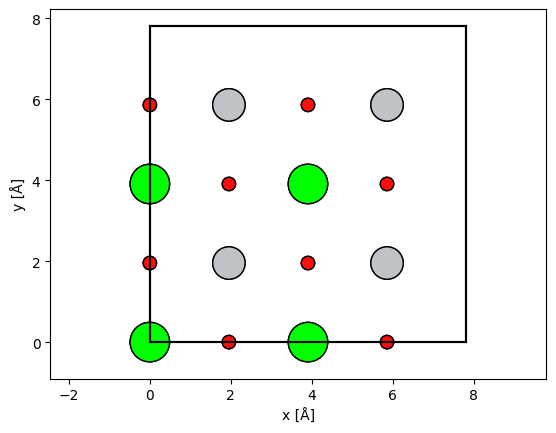

In [ ]:
# Create SrTiO3 structure
a_SrTiO3 = 3.905

atoms = ase.Atoms(
    'SrTiO3',
    scaled_positions = np.array([
        (0,0,0),
        (0.5,0.5,0.5),

        (0.5,0.5,0.0),
        (0.0,0.5,0.5),
        (0.5,0.0,0.5),


    ]),

    cell = (a_SrTiO3,a_SrTiO3,a_SrTiO3),
    # pbc = (1,1,1)

)

abtem.show_atoms(
    atoms * (2,2,2),
    plane='xy',
    scale_atoms = 0.25,
);


Now let's choose the zone axis - is there a projection direction where we don't have and columns of multiple atomic species?

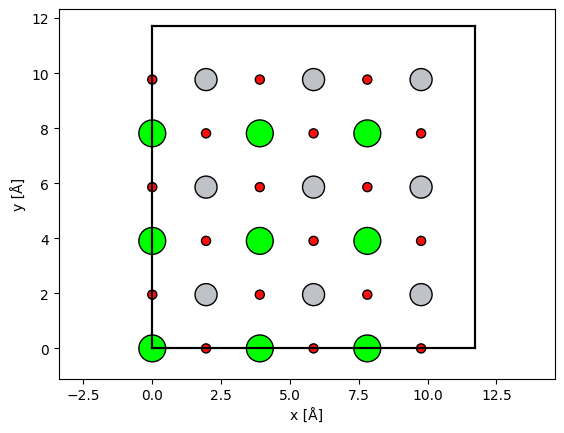

In [ ]:
# Rotate atoms to a [100],[110] or [111] zone axis.  Keep the cell ~1x1 nm in size!  Otherwise your simulation may take a very long time.

atoms_rotate = atoms.copy()
atoms_rotate.rotate(
    [0,0,1],
    [0,0,1],
    rotate_cell = True,
)
atoms_rotate = abtem.structures.orthogonalize_cell(
    atoms_rotate,
    max_repetitions = 2,
) * (3,3,1)

abtem.show_atoms(
    atoms_rotate * 1,
    plane='xy',
    scale_atoms = 0.25,
);

In [ ]:
atoms_rotate.cell

Cell([11.715, 11.715, 3.905])

Initialize the simulation using these parameters:
- energy = 80 kV
- semiangle = 30 mrads
- defocus = 0 A
- sampling = 0.16 A

Try to aim for a thickness of ~5 nm.  This is about as thin as a TEM sample can realistically get. Typical simulations will be thicker, but for the sake of time let's keep the sample thin for now.

In [ ]:
# initialize the simulation objects: probe, potential, gridscan

probe = abtem.Probe(
    energy = 80e3,
    semiangle_cutoff = semiangle_cutoff,
    defocus = 0,

)

potential = abtem.Potential(
    atoms_rotate * (1,1,6),
    sampling =0.16,
)
probe.grid.match(potential)

gridscan = abtem.GridScan(
    start = [0,0],
    end = potential.extent,
    sampling=probe.ctf.nyquist_sampling * 1.0
)

In [ ]:
# Define a pixelated detector, with a maximum scattering angle of 80 mrads
pixelated_detector = abtem.PixelatedDetector(max_angle = 80)

In [ ]:
%%time

# Perform the 4DSTEM simulation!
pixelated_measurement = probe.scan(
    scan = gridscan,
    detectors = pixelated_detector,
    potential = potential,
    # pbar = False,
)

Potential:   0%|          | 0/47 [00:00<?, ?it/s]

Scan:   0%|          | 0/784 [00:00<?, ?it/s]

CPU times: user 2min 4s, sys: 454 ms, total: 2min 4s
Wall time: 1min 24s


Keep in mind this is a relatively fast 4DSTEM simulation!  Real world simulations can take many many hours to compute. This is yet another reason why the PRISM algorithm may be helpful.

In fact, if we add inelastic scattering (double channeling) to our simulations, simulation times using the naive algorithm may be measured in YEARS. PRISM is especially useful for these cases, for an example see this paper:
- [Linear-scaling algorithm for rapid computation of inelastic transitions in the presence of multiple electron scattering
](http://dx.doi.org/10.1103/PhysRevResearch.1.033186)


In [ ]:
# Let's examine the dataset shape - why does it have this shape?
pixelated_measurement.shape

(28, 28, 47, 47)

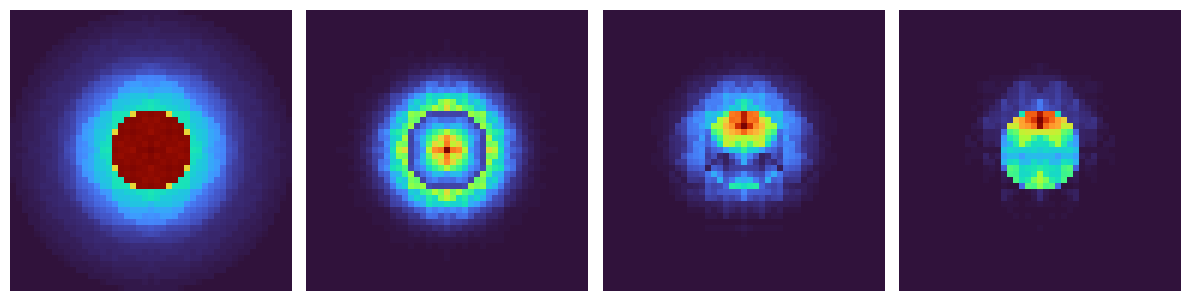

In [ ]:
# Now let's plot some of the diffraction patterns

fig,ax = plt.subplots(1,4,figsize=(12,4))
ax[0].imshow(
    np.mean(pixelated_measurement.array, axis = (0,1))**0.5,
    cmap = cmap,
)
ax[1].imshow(
    pixelated_measurement.array[0,0],
    cmap = cmap,
)
ax[2].imshow(
    pixelated_measurement.array[1,0],
    cmap = cmap,
)
ax[3].imshow(
    pixelated_measurement.array[2,0],
    cmap = cmap,
)

ax[0].axis('off');
ax[1].axis('off');
ax[2].axis('off');
ax[3].axis('off');
fig.tight_layout()

## 4D Data Browser - matplotlib

It will take us a very long time to example these diffraction patterns one at a time!  Instead, let's use a widget to scrub through the data.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
%matplotlib inline

In [ ]:
# data
data = pixelated_measurement.array

# Initial probe positions
init_x, init_y = data.shape[0]//2, data.shape[1]//2

# Create widgets
slider_x = widgets.IntSlider(value=init_x, min=0, max=data.shape[0]-1, description='probe_x')
slider_y = widgets.IntSlider(value=init_y, min=0, max=data.shape[1]-1, description='probe_y')

# Set up figure
with plt.ioff():
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(8, 4))
    plt.tight_layout()

# Precompute and plot mean along kx, ky (left panel)
mean_image = data.mean(axis=(2, 3))
ax_left.imshow(mean_image, cmap='gray')
scatter_marker, = ax_left.plot(
    [init_y], [init_x], color='green', marker='o',
    linestyle='None', markersize = 10, alpha = 0.75)
ax_left.set_title("Mean (kx, ky)")
ax_left.set_xlabel('probe_y')
ax_left.set_ylabel('probe_x')

# Enable dragging of the marker
dragging = {'active': False}

def on_press(event):
    if event.inaxes != ax_left:
        return
    contains, _ = scatter_marker.contains(event)
    if contains:
        dragging['active'] = True

def on_release(event):
    dragging['active'] = False

def on_motion(event):
    if dragging['active'] and event.inaxes == ax_left:
        new_x = int(round(event.xdata))
        new_y = int(round(event.ydata))
        new_x = np.clip(new_x, 0, data.shape[1] - 1)
        new_y = np.clip(new_y, 0, data.shape[0] - 1)
        slider_x.value = new_y
        slider_y.value = new_x

# Add arrow key interaction
def on_key(event):
    x, y = slider_x.value, slider_y.value
    if event.key == 'up':
        slider_x.value = max(0, x - 1)
    elif event.key == 'down':
        slider_x.value = min(data.shape[0] - 1, x + 1)
    elif event.key == 'left':
        slider_y.value = max(0, y - 1)
    elif event.key == 'right':
        slider_y.value = min(data.shape[1] - 1, y + 1)

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('key_press_event', on_key)

# Function to update plots based on sliders
def update_plot(probe_x, probe_y):
    scatter_marker.set_data([probe_y], [probe_x])

    ax_right.clear()
    specific_image = data[probe_x, probe_y]
    ax_right.imshow(specific_image, cmap='magma')
    ax_right.set_title(f"Image at ({probe_x}, {probe_y})")
    ax_right.set_xlabel('kx')
    ax_right.set_ylabel('ky')

    fig.canvas.draw()
    display(fig)

# Interactive widget
ui = widgets.HBox([slider_x, slider_y])
out = widgets.interactive_output(update_plot, {'probe_x': slider_x, 'probe_y': slider_y})

# Display widgets and plot
display(ui, out)

Output()

## 4D Data Browser - plotly

It will take us a very long time to example these diffraction patterns one at a time!  Instead, let's use a widget to scrub through the data.


In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:

# Initial probe positions
init_x, init_y = data.shape[0] // 2, data.shape[1] // 2

# Mean image along kx, ky
mean_image = data.mean(axis=(2, 3))

# Create interactive Plotly figures
fig_mean = go.FigureWidget(
    data=[go.Heatmap(z=mean_image, colorscale='gray'),
          go.Scatter(x=[init_y], y=[init_x], mode='markers', marker=dict(color='green', size=10))],
    layout=go.Layout(height=400, width=400, title='Mean (kx, ky)')
)

fig_specific = go.FigureWidget(
    data=[go.Heatmap(z=data[init_x, init_y], colorscale='magma')],
    layout=go.Layout(height=400, width=400, title=f'Image at ({init_x}, {init_y})')
)

# Widgets
slider_x = widgets.IntSlider(value=init_x, min=0, max=data.shape[0]-1, description='probe_x')
slider_y = widgets.IntSlider(value=init_y, min=0, max=data.shape[1]-1, description='probe_y')

# Update function
def update(change):
    probe_x, probe_y = slider_x.value, slider_y.value
    with fig_mean.batch_update():
        fig_mean.data[1].x = [probe_y]
        fig_mean.data[1].y = [probe_x]
    with fig_specific.batch_update():
        fig_specific.data[0].z = data[probe_x, probe_y]
        fig_specific.layout.title = f'Image at ({probe_x}, {probe_y})'

# Keyboard interaction
def on_key(event):
    if event['key'] == 'ArrowUp':
        slider_x.value = max(0, slider_x.value - 1)
    elif event['key'] == 'ArrowDown':
        slider_x.value = min(data.shape[0] - 1, slider_x.value + 1)
    elif event['key'] == 'ArrowLeft':
        slider_y.value = max(0, slider_y.value - 1)
    elif event['key'] == 'ArrowRight':
        slider_y.value = min(data.shape[1] - 1, slider_y.value + 1)

# Connect sliders to update function
slider_x.observe(update, names='value')
slider_y.observe(update, names='value')

# Attach keyboard listener
fig_mean.layout.on_change(on_key, 'uirevision')

# Display widgets and figures side-by-side
ui = widgets.HBox([slider_x, slider_y])
figs = widgets.HBox([fig_mean, fig_specific])

display(ui, figs)

    'data': [{'colorscale': [[0.0, 'rgb(0, 0, 0)'], [0.09090909090909091, 'rgb(1…